# Connectivity analysis

Within this section the `connectivity analyses`, that is `ROI to ROI connectivity` and `voxel to voxel connectivity`, are shown, explained and set up in a way that they can be rerun and reproduced. In short, we employed `task-based functional connectivity` through [NiBetaSeries]() analysis, to investigate if condition specific information flow within the `auditory cortex` provides insights concerning the proposed `functional principles`. The analysis is divided into the following sections: 

[Prerequisites]() 
* [Auditory cortex atlas creation]() 
* [Auditory cortex connectivity working model]() 
* [Event file adaption]() 
* [Evaluating confounds]() 

[NiBetaSeries]() 
* [model fitting]() 
* [spatial beta series transformation]() 

[Correlation analysis - ROI to ROI]() 
* [Condition-specific functional connectivity]()
* [Comparison of condition-specific functional connectivity]()

[Correlation analysis - voxel to voxel]() 
* [Diffusion map embedding - Gradients]()
* [Diffusion map embedding - component plots]()

We provide more detailed information and explanations in the respective sections. As mentioned before, we're working with `derivatives` here and thus we can share them, meaning that you can rerun the analyses either by downloading this page as a [Jupyter Notebook]() (via the download button at the top) or interactively via a cloud instance through the amazing [mybinder project]() (the little rocket at the top). We recommend the later to spare installation and `conda environment` related problems. One more thing... Please note, that here `derivatives` refers to the computed `Beta Series` (i.e. `condition specific trial-wise beta estimates`) which we provide via the [project's OSF page]() because their computation is computationally very expensive and would never run via the resources available through `binder`. However, we included the code and explainations depicting how this steps were run. The code that will download the required data is included in the respective sections.


As usual, we will start with importing all necessary `modules` and `functions`.

In [1]:
from os.path import join as opj
from os.path import basename as opb
from os import makedirs, listdir

import numpy as np
from glob import glob
import pandas as pd
import nibabel as nb
from nilearn import image
from nilearn.plotting import plot_roi, plot_matrix

from mne.viz import circular_layout, plot_connectivity_circle
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
import seaborn as sns
import ptitprince as pt
import plotly.express as px
import plotly.graph_objects as go

from subprocess import Popen, PIPE, STDOUT  
%matplotlib inline

Let's also gather and set some important paths. This includes the path to the general `derivatives` directory, as well as `analyses` specific ones. In more detail, we of course aim to keep it as [BIDS]()-y as possible and therefore set a path for the `Connectivity analyses` here. To keep results and necessary `prerequisites` separate (keeping it tidy), we also create a dedicated directory which will include the `auditory cortex atlas`, as well as the `input data`.

In [2]:
derivatives_path = '/data/mvs/derivatives/'

roi_mask_path ='/data/mvs/derivatives/ROIs_masks/'

prereq_path = '/data/mvs/derivatives/connectivity/prerequisites/'

results_path = '/data/mvs/derivatives/connectivity/'

## Prerequisites  

### Atlas creation
At first, we need to create an `atlas` and corresponding `.csv` file to extract `ROI` specific `beta series`. While the usual approach would be to utilize an existing whole brain atlas, we're going to rely on our `auditory cortex parcellation` introduced in the [Auditory cortex working model section]() given that we are interested in its proposed functional principles. only a subset of regions, comprising the [auditory cortex](). In more detail, this entails the [STP](), including [HG](), [PP]() and [PT](), and the upper banks of the [STG](), including [aSTG]() and [pSTG](). At first, we gather them within a list (please note that we will exclude the `auditory cortex masks`): 

In [3]:
rois = [roi for roi in glob(opj(roi_mask_path, '*.nii.gz'))
        if not 'AC' in opb(roi)]
rois.sort()
rois

['/data/mvs/derivatives/ROIs_masks/tpl-MNI152NLin6Sym_res_02_desc-HGleft_mask.nii.gz',
 '/data/mvs/derivatives/ROIs_masks/tpl-MNI152NLin6Sym_res_02_desc-HGright_mask.nii.gz',
 '/data/mvs/derivatives/ROIs_masks/tpl-MNI152NLin6Sym_res_02_desc-PPleft_mask.nii.gz',
 '/data/mvs/derivatives/ROIs_masks/tpl-MNI152NLin6Sym_res_02_desc-PPright_mask.nii.gz',
 '/data/mvs/derivatives/ROIs_masks/tpl-MNI152NLin6Sym_res_02_desc-PTleft_mask.nii.gz',
 '/data/mvs/derivatives/ROIs_masks/tpl-MNI152NLin6Sym_res_02_desc-PTright_mask.nii.gz',
 '/data/mvs/derivatives/ROIs_masks/tpl-MNI152NLin6Sym_res_02_desc-aSTGleft_mask.nii.gz',
 '/data/mvs/derivatives/ROIs_masks/tpl-MNI152NLin6Sym_res_02_desc-aSTGright_mask.nii.gz',
 '/data/mvs/derivatives/ROIs_masks/tpl-MNI152NLin6Sym_res_02_desc-pSTGleft_mask.nii.gz',
 '/data/mvs/derivatives/ROIs_masks/tpl-MNI152NLin6Sym_res_02_desc-pSTGright_mask.nii.gz']

Great. Now, we will use [nilearn's concat_imgs](http://nilearn.github.io/modules/generated/nilearn.image.concat_imgs.html) & [nilearn's math_img](http://nilearn.github.io/modules/generated/nilearn.image.math_img.html) to concatenate our `ROI images` and create the corresponding atlas:

In [4]:
atlas = image.concat_imgs(rois)
atlas = image.math_img('np.sum(np.arange(1, atlas.shape[-1] + 1)[None, None, None] * atlas, axis=-1)',
                       atlas=atlas)
atlas.to_filename(opj(prereq_path, 'atlas/tpl-MNI152NLin2009cAsym_res-02_desc-ACatlas.nii.gz'))

So far so good, let's have a look by overlaying the atlas on the `MNI152 template brain`: 

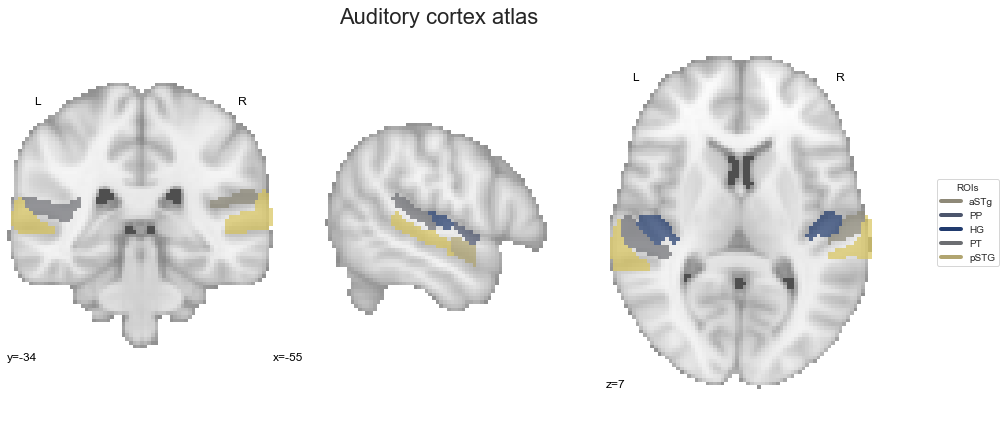

In [5]:
sns.set_style('white')
plt.rcParams["font.family"] = "Arial"   


ac_atlas_cmap = sns.color_palette('cividis')

fig=plt.figure(num=None, figsize=(12, 6))

plot_roi(opj(prereq_path, 'atlas/tpl-MNI152NLin2009cAsym_res-02_desc-ACatlas.nii.gz'), 
                               draw_cross=False, cmap=ListedColormap(ac_atlas_cmap), cut_coords=[-55, -34, 7], figure=fig)

roi_legend = [Line2D([0], [0], color=ac_atlas_cmap[3], lw=4, label='aSTg'),
              Line2D([0], [0], color=ac_atlas_cmap[1], lw=4, label='PP'), 
              Line2D([0], [0], color=ac_atlas_cmap[0], lw=4, label='HG'), 
              Line2D([0], [0], color=ac_atlas_cmap[2], lw=4, label='PT'),
              Line2D([0], [0], color=ac_atlas_cmap[4], lw=4, label='pSTG')]
plt.legend(handles=roi_legend, bbox_to_anchor=(1.5,0.5), loc="right", title='ROIs')

plt.text(-215, 90, 'Auditory cortex atlas',
         fontsize=22)

Looks alright (please note that the "holes" are based on the slice and because we didn't dilate the ROIs). Next, we need to provide information about the atlas, more precisely `label names` and their `index`. To do so, we will follow the order of ROIs as indicated above:

In [ ]:
regions = ['HG_lh', 'HG_rh', 'PP_lh', 'PP_rh', 'PT_lh', 
           'PT_rh', 'aSTG_lh', 'aSTG_rh', 'pSTG_lh', 'pSTG_rh']

In [ ]:
atlas_rois_df = pd.DataFrame({'index': np.arange(1,11),
                              'regions': regions})
atlas_rois_df.to_csv(opj(prereq_path, 'atlas/AC_atlas_regions.txt'), sep="\t", index=False)
atlas_rois_df

index  regions
0      1    HG_lh
1      2    HG_rh
2      3    PP_lh
3      4    PP_rh
4      5    PT_lh
5      6    PT_rh
6      7  aSTG_lh
7      8  aSTG_rh
8      9  pSTG_lh
9     10  pSTG_rh

In order to provide folks with an idea of the `atlas` and corresponding `connections` we created, we are going to visualize the resulting network structure. More precisely, we will visualize the network structure "as is", meaning fully connected and not weighted. We will use this as a graphical explanation and a starting point from which we will specify network model variants later on. </br>
In a first step we will define a connectivity matrix that is a) fully connected, b) no intrinsic connections and c) have different 'weights' for intra- and inter-hemispheric connections respectively. Please note that the c) is only included to visualize these connections differently in the graphic we are going to create.

In [ ]:
network_structure_full = np.array([[0., 2., 1., 2., 1., 2., 1., 2., 1., 2.],
                                   [2., 0., 2., 1., 2., 1., 2., 1., 2., 1.],
                                   [1., 2., 0., 2., 1., 2., 1., 2., 1., 2.],
                                   [2., 1., 2., 0., 2., 1., 2., 1., 2., 1.],
                                   [1., 2., 1., 2., 0., 2., 1., 2., 1., 2.],
                                   [2., 1., 2., 1., 2., 0., 2., 1., 2., 1.],
                                   [1., 2., 1., 2., 1., 2., 0., 2., 1., 2.],
                                   [2., 1., 2., 1., 2., 1., 2., 0., 2., 1.],
                                   [1., 2., 1., 2., 1., 2., 1., 2., 0., 2.],
                                   [2., 1., 2., 1., 2., 1., 2., 1., 2., 0.]])

Coolio, now to the graphic itself. What follows might seem a bit rough and convoluted and there are definitely other, more suitable ways of achieving the wanted outcome. However, this approach worked for nicely within the project and we are going to put it into a function that we can use throughout the analyses.

In [ ]:
def plot_auditory_cortex_connectome(network_connections, name=None, model=True, n_lines=None):

    regions = atlas_rois_df['regions'].str.replace('_', ' ', regex=True)


    # Reorder the labels based on their location
    lh_labels = ['pSTG lh', 'PT lh', 'HG lh', 'PP lh', 'aSTG lh']

    # For the right hemi
    rh_labels = [label[:-2] + 'rh' for label in lh_labels]


    # Save the plot order
    node_order = lh_labels[::-1] + rh_labels

    node_angles = circular_layout(regions, node_order, start_pos=90,
                                  group_boundaries=[0, len(atlas_rois_df['regions']) // 2])


    cmap = ListedColormap(sns.color_palette('cividis'))#ac_atlas_cmap)

    node_color = []

    #for value in [0, 0.15, 0.30, 0.45, 0.60]:

    for value in [0, 1, 2, 3, 4]:

        node_color.append(cmap(value)[:-1])
        node_color.append(cmap(value)[:-1])

    node_color

    fig = plt.figure(num=None, figsize=(8, 8), facecolor='white')
    fig.text(0.85, 0.85, 'right hemisphere', size=13)
    fig.text(0, 0.85, 'left hemisphere', size=13)


    l1 = matplotlib.lines.Line2D([0.515, 0.515], [0.15, 0.85], 
                                 color='black', linestyle='--', transform=fig.transFigure, figure=fig)

    
    if model:
        anterior_path = plt.arrow(1, 0.52, 0, 0.2, ec='none', color='black', linestyle='--', head_width=0.01, transform=fig.transFigure, figure=fig, clip_on=False)
        posterior_path = plt.arrow(1, 0.48, 0, -0.2, ec="none", color='black', head_width=0.01, transform=fig.transFigure, figure=fig, clip_on=False)

        fig.text(1.02, 0.485, '      primary\n auditory cortex', size=13)
        fig.text(1.02, 0.7, 'anterior regions', size=13)
        fig.text(1.02, 0.3, 'posterior regions', size=13)


        fig.lines.extend([l1, anterior_path, posterior_path])

        cmap_connections = plt.cm.Set1_r
        

    custom_lines = [matplotlib.lines.Line2D([0], [0], color=cmap_connections(0), lw=4),
                    matplotlib.lines.Line2D([0], [0], color='black', lw=4, linestyle=':'),
                    matplotlib.lines.Line2D([0], [0], color=cmap_connections(10), lw=4)]


    fig.legend(custom_lines, ['intra-hemispheric', 'hemisphere border', 'inter-hemispheric'], bbox_to_anchor=(1.15, 0.07), loc='lower center', frameon=False)


    if name is None:
        title = 'Auditory cortex parcellation and connections'
    else:
        title='Auditory cortex parcellation and connections - %s' % name
    
    if n_lines is not None:
        n_lines=n_lines
    
    plot_connectivity_circle(network_connections, regions, 
                             node_angles=node_angles, n_lines=n_lines,
                             fig=fig, title=title, fontsize_title=20,
                             colorbar=False, padding=0.7, fontsize_names=10,
                             facecolor='white', textcolor='black', node_edgecolor='white', 
                             node_colors=node_color, colormap=cmap_connections)

Puh, that was something else, eh? Let's check it out:

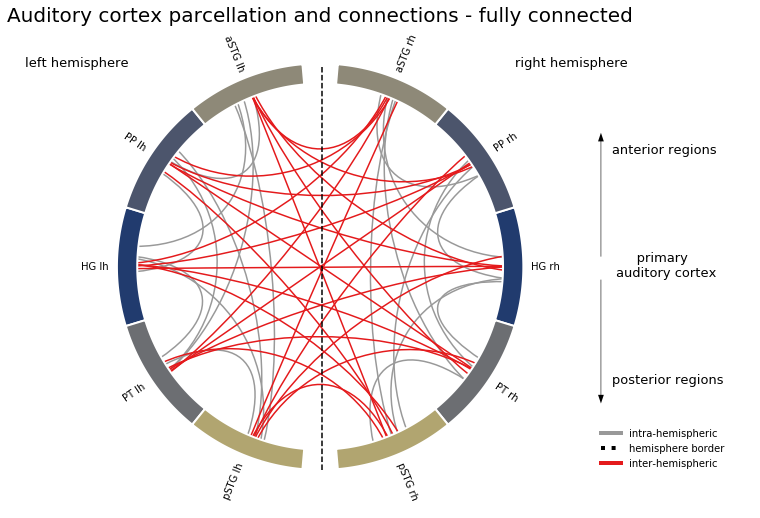

In [ ]:
plot_auditory_cortex_connectome(network_structure_full, name='fully connected')

But the graphic is quite nice and informative (at least in my obviously unbiased opinion). We can see the structure of the network based on the parcellation (atlas) of the auditory cortex we used. We marked the different hemispheres as well as the corresponding connections between their homotopic and heterotopic regions. We also included information with regard to spatial aspects (anterior vs. posterior pathways). </br>

Now it's time to go to the next section, that is adapting our `event files` to be compliant with the  `NiBetaSeries` package.

### Event file adaption

As we intend to use [`NiBetaSeries`](https://nibetaseries.readthedocs.io/en/stable/), we need to adapt our `event files` as it assumes, or rather expects a certain structure as described in the corresponding section of the [`NiBetaSeries` docs](https://nibetaseries.readthedocs.io/en/stable/auto_examples/plot_run_nibetaseries.html#manipulate-events-file-so-it-satifies-assumptions). Luckily, our event files are already [BIDS compliant](https://bids-specification.readthedocs.io/en/stable/04-modality-specific-files/05-task-events.html) which should bring us almost all the way to be  `NiBetaSeries compliant`. Let's check what the latter needs and what we already have. </br>    
From the [`NiBetaSeries` docs](https://nibetaseries.readthedocs.io/en/stable/auto_examples/plot_run_nibetaseries.html#manipulate-events-file-so-it-satifies-assumptions) we know that our `event files` need to have the following information: `onset`, `duration`, `trial_type` and `correct`. Great, now we can check and establish the adaption using the `event files` of `sub-01`. First, we load the `event file` of the first run using [pandas](https://pandas.pydata.org/):

In [ ]:
sub01_events = pd.read_csv(opj(data_path, 'sub-01/func/sub-01_task-mvs_run-01_events.tsv'), sep='\t')

Now, let's inspect it:

In [ ]:
sub01_events

Unnamed: 0 trial_type    onset  duration
0            0      Music    4.710      1.87
1            1      Music    8.726      1.76
2            2      Music   20.776      1.68
3            3      Music   24.792      1.76
4            4      Music   28.809      1.57
..         ...        ...      ...       ...
85          85      Voice  337.496      1.39
86          86      Voice  341.513      1.97
87          87      Voice  353.546      1.71
88          88      Voice  357.562      1.43
89          89      Voice  361.562      1.86

[90 rows x 4 columns]

As predicted, we are almost there already, as the `event files` have `onset`, `duration` and `trial_type`. We're only missing `correct`. We can add this as easy as:

In [ ]:
sub01_events['correct'] = 'Y'

In [ ]:
sub01_events

Unnamed: 0 trial_type    onset  duration correct
0            0      Music    4.710      1.87       Y
1            1      Music    8.726      1.76       Y
2            2      Music   20.776      1.68       Y
3            3      Music   24.792      1.76       Y
4            4      Music   28.809      1.57       Y
..         ...        ...      ...       ...     ...
85          85      Voice  337.496      1.39       Y
86          86      Voice  341.513      1.97       Y
87          87      Voice  353.546      1.71       Y
88          88      Voice  357.562      1.43       Y
89          89      Voice  361.562      1.86       Y

[90 rows x 5 columns]

The beauty of `pandas` (meant here is the python package, but the same holds true for the animal as well)... .
While we're at it, we can address the mysterious `Unnamed: 0` column. This is the result of saving `pandas DataFrame` to file without specifying the following `index=False`. Instead of correcting it and working with "fitting" files from the beginning, I decided to leave them as is to show that many problems/errors can occur along the way of an analysis, but as long as you are aware of them and address them in a reproducible and open way, it's all good. These things happen, even to the most experienced folks (to which I don't belong). As it doesn't contain useful information, but redundant, we can just delete it. Again, with `pandas` it's as easy as: 

In [ ]:
del sub01_events['Unnamed: 0']

Now, everything we need to do is to save our modified `events file`. While it's strictly not "wrong" to just overwrite the original file within the `BIDS root` directory, I decided to place them in the `derivatives` directory that entails the data processed within the `NiBetaSeries` analyses. Thus, we will add the `desc` identifier to note this accordingly:  

In [ ]:
sub01_events.to_csv(opj(derivatives_path, 'data_prerequisites', 'sub-01_task-mvs_run-01_events_desc-nibetaseries.tsv'))

To avoid doing this for all participants and their `event files` manually (and a lot of potential errors within that process), we'll define a short function:

In [ ]:
def adapt_eventfiles_nibetaseries(event_file):
    
    import os.path
    
    filename_tmp = event_file[event_file.rfind('/')+1:]
    
    participant_tmp = event_file[event_file.rfind('/')+1:event_file.rfind('/')+7]
    
    event_file_tmp = pd.read_csv(event_file, sep='\t')
    
    event_file_tmp['correct'] = 'Y'
    
    del event_file_tmp['Unnamed: 0']
    
    if not os.path.exists(opj(derivatives_path, 'data_prerequisites/event_files/%s' %participant_tmp)):
        
        makedirs(opj(derivatives_path, 'data_prerequisites/event_files/%s' %participant_tmp))
    
    event_file_tmp.to_csv(event_file, index=False, sep='\t')

Now, we only have to gather all `event files` using glob:

In [ ]:
list_event_files = glob(opj(data_path, '*/*/*events.tsv'))
list_event_files.sort()

and apply our function to every single one using a `for loop`:

In [ ]:
for event_file in list_event_files:
    adapt_eventfiles_nibetaseries(event_file)

### Check confounds

As for all other types of analyses within the realm of linear models applied to fMRI data, checking and incorporating confounds is necessary and important. Following `BIDS`, they are (should be) stored alongside the preprocessed images in the `preprocessing` corresponding folder of the `/derivatives` directory. For the data at hand, let's say the first participant `sub-01` they are called: `sub-01_task-mvs_run-01_desc-confounds_regressors.tsv` and contain the following information:

In [ ]:
pd.read_csv('/data/mvs/preprocessing/sub-01/func/sub-01_task-mvs_run-01_desc-confounds_regressors.tsv', sep="\t")

trans_x   trans_y   trans_z     rot_x     rot_y     rot_z  white_matter  \
0    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000     -1.502010   
1    0.006862 -0.039911 -0.023868  0.000537 -0.000208  0.000173     -1.665055   
2    0.000248 -0.033173 -0.020424  0.000789 -0.000198  0.000198     -1.455152   
3    0.000808 -0.010968 -0.005223  0.001199 -0.000459  0.000025     -1.621729   
4   -0.002599  0.083570  0.030288 -0.000253  0.000043 -0.000099     -1.288876   
..        ...       ...       ...       ...       ...       ...           ...   
785 -0.108433 -0.068326 -0.110301  0.001941 -0.001557 -0.002760      0.937084   
786 -0.103787 -0.046885 -0.108684  0.001634 -0.001611 -0.002875      0.438706   
787 -0.120564 -0.015005 -0.100488  0.001792 -0.001597 -0.003026      0.157408   
788 -0.118234  0.020811 -0.107692  0.000639 -0.001524 -0.003150     -0.176196   
789 -0.123682 -0.045449 -0.106099  0.001523 -0.001420 -0.003110      0.391247   

          csf  
0   -0.423443  
1   -0.481281  
2   -1.819274  
3   -1.624893  
4   -0.910469  
..        ...  
785  1.691596  
786  1.077597  
787  1.916833  
788  0.789305  
789  1.270234  

[790 rows x 8 columns]

As you can see, the preprocessing pipeline provided us with 8 confounds: `trans_x`, `trans_y`, `trans_z`, `rot_x`, `rot_y`, `rot_z`, `white_matter` and	`csf` for each of the acquired and preprocessed 790 images. While the first six are `motion related confounds` obtained through motion correction entailing the deviation from the mean image by means of `rotation` and `translation` in `x`, `y`, `z`, the last two entail the `z-scored` mean signal present in `white_matter` and `csf`. The question of which and how many confound regressors should be included in a given model is discussed in a very active debatte with no clear "one-approach-fits-all" outcome as everything is dependent on the data and factors like the correlation between confounds. Compared to comprehensive pipelines like [fmriprep](https://fmriprep.readthedocs.io/en/stable/outputs.html#confounds) we have only a few, but however the most common ones on which important's most folks converge. To keep things comparable to the model we run during the [univariate analyses]() as the basis for the [MVPA](), we will include only the `motion related confounds` within the subsequent `NiBetaSeries` analysis for which we are now ready.

**Please note**: As mentioned before, the to-be computed `beta series` are the derivatives we can share and thus work with here. Based on that and given that the computation of these files is super heavy (computationally speaking), we will only show and explain how we computed them, but not actually run code. As in the [MVPA](), we will provide code that will download these files from the project's [OSF page]().

## NiBetaSeries 

As we now have and checked everything we need to run the planned `NiBetaSeries` analysis, we can set it up accordingly hereby closely following the [`NiBetaSeries` docs](https://nibetaseries.readthedocs.io/en/stable/usage.html). In general, we'll conduct a two step procedure: first, we'll compute responses to our presented conditions per participant, trial and run and second, transform the resulting `beta series images` to the `MNI152 template space `. The latter is required as the first step will be conducted in each participant's `native functional space`. Comparable to the [univariate results](), we will apply spatial transformations only to `model outcomes` (here `beta series`). For the analyses, we need to define some paths that point to the data:  

In [ ]:
out_dir = '/data/mvs/derivatives/connectivity/results/nibetaseries'
work_dir =  '/data/mvs/derivatives/connectivity/reults/nibetaseries/work'
data_dir = '/data/mvs'

### Model fitting

Next, we define how `NiBetaSeries` should be run, printing the resulting `bash` command for evaluation:

In [ ]:
cmd = """\
nibs -c rot_x rot_y rot_z trans_x trans_y trans_y \
--participant-label 01 \
--estimator lss \
--hrf-model spm \
-w {work_dir} \
-sp {space_label} \
--sm {smoothing} \
--description-label 'preproc' \
{bids_dir} \
preprocessing \
{out_dir} \
participant 
""".format(bids_dir=data_dir,
           out_dir=out_dir,
           work_dir=work_dir,
           space_label='individual',
           smoothing=0.0)

print("The NiBetaSeries Command looks as follows:\n", cmd)

The NiBetaSeries Command looks as follows:
 nibs -c rot_x rot_y rot_z trans_x trans_y trans_y --participant-label 01 --estimator lss --hrf-model spm -w /data/mvs/derivatives/connectivity/reults/nibetaseries/work -sp individual --sm 0.0 --description-label 'preproc' /data/mvs/ preprocessing /data/mvs/derivatives/connectivity/results/nibetaseries/ participant 



In more detail, we include our six confounds `rot_x, rot_y, rot_z, trans_x, trans_y and trans_y`, running the analysis for `sub-01`. For the model, we use a `lss` (`least squares separate`) estimator and the `SPM hemodynamic model` and indicate the `space` we are running the analysis in (`individual`). We set `smoothing` to `0.0` as we already applied a `6 mm FWHM` Gaussian smoothing kernel to the images during [preprocessing](). We furthermore set the `description label` to use `preproc` (`preprocessed`) data and define `working`, `data` and `output` directories, as well as the name of the utilized `preprocessing pipeline` (`preprocessing`) and that we want to run the analysis on the `participant` level. We don't specify a `high-pass` filter as `NiBetaSeries` default of `0.0078 Hz` is what we want anyway.

So far, so good. Let's run it:

In [ ]:
p = Popen(cmd, shell=True, stdout=PIPE, stderr=STDOUT)

while True:
    line = p.stdout.readline()
    if not line:
        break
    print(line)

b'200625-20:03:42,408 nipype.utils INFO:\n'
b'\t Running nipype version 1.4.2 (latest: 1.5.0)\n'
b'200625-20:03:42,773 nipype.workflow INFO:\n'
b"\t Workflow nibetaseries_participant_wf settings: ['check', 'execution', 'logging', 'monitoring']\n"
b'200625-20:03:42,796 nipype.workflow INFO:\n'
b'\t Running in parallel.\n'
b'200625-20:03:42,802 nipype.workflow INFO:\n'
b'\t [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 113.22/113.22, Free processors: 40/40.\n'
b"opt/miniconda3/lib/python3.7/site-packages/bids/layout/models.py:147: UserWarning: Accessing entities as attributes is deprecated as of 0.7. Please use the .entities dictionary instead (i.e., .entities['task'] instead of .task.\n"
b'  % (attr, attr))\n'
b"opt/miniconda3/lib/python3.7/site-packages/bids/layout/models.py:147: UserWarning: Accessing entities as attributes is deprecated as of 0.7. Please use the .entities dictionary instead (i.e., .entities['run'] instead of .run.\n"
b'  % (attr, attr))\n'
b"opt/mi

That seems to work, great! Now we set up a little `for-loop` that runs `NiBetaSeries` for each `participant`:

In [ ]:
for part in ['sub-0%s' %s for s in range(1,10)] + ['sub-%s' %s for s in range(10,25)]:
    
    cmd = """\
    nibs -c rot_x rot_y rot_z trans_x trans_y trans_y \
    --participant-label {part} \
    --estimator lss \
    --hrf-model spm \
    -w {work_dir} \
    -sp {space_label} \
    --sm {smoothing} \
    --description-label 'preproc' \
    {bids_dir} \
    preprocessing \
    {out_dir} \
    participant 
    """.format(part=part,
               bids_dir=data_dir,
               out_dir=out_dir,
               work_dir=work_dir,
               space_label='individual',
               smoothing=0.0)

    print("The NiBetaSeries Command looks as follows:\n", cmd)

    p = Popen(cmd, shell=True, stdout=PIPE, stderr=STDOUT)

    while True:
        line = p.stdout.readline()
        if not line:
            break
        print(line)

The NiBetaSeries Command looks as follows:
     nibs -c rot_x rot_y rot_z trans_x trans_y trans_y     --participant-label sub-01     --estimator lss     --hrf-model spm     -w /data/mvs/derivatives/connectivity/reults/nibetaseries/work     -sp individual     --sm 0.0     --description-label 'preproc'     /data/mvs/     preprocessing     /data/mvs/derivatives/connectivity/results/nibetaseries/     participant 
    
b'200625-21:03:24,424 nipype.utils INFO:\n'
b'\t Running nipype version 1.4.2 (latest: 1.5.0)\n'
b'200625-21:03:24,786 nipype.workflow INFO:\n'
b"\t Workflow nibetaseries_participant_wf settings: ['check', 'execution', 'logging', 'monitoring']\n"
b'200625-21:03:24,797 nipype.workflow INFO:\n'
b'\t Running in parallel.\n'
b'200625-21:03:24,801 nipype.workflow INFO:\n'
b'\t [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 113.22/113.22, Free processors: 40/40.\n'
b'200625-21:03:24,901 nipype.workflow INFO:\n'
b'\t [Job 0] Cached (nibetaseries_participant_wf.sing

What we have as output are `betaseries` files per `condition` and `run`, each containing `n` images where `n` reflects the number of presentations of a given condition per run. Thus, we have six `betaseries`: for each of two runs, one for `music`, `singing` and `voice` respectively. 

In [ ]:
listdir(opj(out_dir, 'sub-01/func'))

['sub-01_task-mvs_run-2_space-individual_desc-Singing_betaseries.nii.gz',
 'sub-01_task-mvs_run-1_space-individual_desc-Music_betaseries.nii.gz',
 'sub-01_task-mvs_run-1_space-individual_desc-Singing_betaseries.nii.gz',
 'sub-01_task-mvs_run-2_space-individual_desc-Music_betaseries.nii.gz',
 'sub-01_task-mvs_run-1_space-individual_desc-Voice_betaseries.nii.gz',
 'sub-01_task-mvs_run-2_space-individual_desc-Voice_betaseries.nii.gz']

And each `betaseries` consists of `30` images which matches with how often the conditions were presented:

In [ ]:
list_beta = glob(opj(out_dir, 'nibetaseries_transform/*/*.nii.gz'))
list_beta.sort()

for betaseries in list_beta:
    print(nb.load(betaseries).shape)

(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 97, 30)
(97, 115, 

We can double check the number of presentations of a given `condition` using `sub-01` and the `music condition` as an example:

In [ ]:
pd.read_csv(opj(data_path, 'sub-01/func/sub-01_task-mvs_run-01_events.tsv'), sep='\t').query('trial_type == "Music"').trial_type.count()

30

As done in the [MVPA](), we will exclude the data of `sub-06` as no reliable activation could be detected in the `univariate analyses`:

In [ ]:
del list_beta[30:36]

### Spatial beta series transformation

Given that the `beta series` are in each participant's `native functional space`, but our `auditory cortex atlas` from which we want to extract `ROI` values is in `MNI152 template space`, we need to apply some sort of `spatial transformation` between these `spaces`. In general, we have two options: `transform` the `auditory cortex atlas` into each participant's `functional native space` or `transform` each participant's `beta series` into the `MNI152 template space`. Following the [MVPA](), we will go with the second option as it will streamline the planned analyses a bit more. Luckily, we already computed everything we need during the [preprocessing](). This includes the `native functional space to native anatomical space registration` and the `native anatomical space to template space registration`. We can even re-use the majority of the code from the corresponding section in [preprocessing and individual level analyses]().As done there, we will gather the respective `transformation matrices`, combine them and then apply them to the `beta series`. A first, we are going to import the necessary `modules` and `functions`:     

In [ ]:
from os.path import join as opj
from os import mkdir, remove
from nipype.interfaces.ants import  ApplyTransforms
from nipype.interfaces.freesurfer import FSCommand, Binarize, Label2Label
from nipype.interfaces.utility import Function, IdentityInterface, Merge
from nipype.interfaces.io import SelectFiles, FreeSurferSource, DataSink
from nipype.pipeline.engine import Workflow, Node, MapNode
from nipype.interfaces.fsl import FLIRT
from glob import glob
from shutil import copy

Next, we will set up the additional `paths` we need, including the `registration` directory.

In [ ]:
input_dir_reg = '/data/mvs/derivatives/registration' # name of registration output folder
input_dir_betaseries = '/data/mvs/derivatives/nibetaseries/' # location of ROI folder

Where should the outputs be stored? How about here:

In [ ]:
output_dir = 'derivatives/nibetaseries/nibetaseries_transform'  # name of norm output folder
working_dir = 'derivatives/nibetaseries/nibetaseries_transform/working_dir'  # name of norm working directory

We also need to define a list of `participants` we want to iterate over:

In [ ]:
subject_list = [] # create the subject_list variable

#create a study specific subject list
for i in range(1,10):    
       subject_list.append('sub-0%s' %i)

for i in range(10,25):   
       subject_list.append('sub-%s' %i)

For the `transformation` we only need two `processing nodes`: one that `merges` the `transformation matrices` and one that `transforms` the `beta series`. For the first, we will use [Nipype's Merge function](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.utility.base.html#merge) and for the second [ANTs' ApplyTransforms function](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.ants.html#applytransforms). We define and set them up as we did during the [preprocessing and individual level analyses section](), starting with the `merge` node:

In [ ]:
merge = Node(Merge(2), iterfield=['in2'], name='mergexfm')

No problem here. The `ApplyTransforms` node looked like this:

In [ ]:
transform_betaseries = MapNode(ApplyTransforms(args='--float',
                                  input_image_type=3,
                                  interpolation='NearestNeighbor',
                                  invert_transform_flags=[False, False],
                                  num_threads=1,
                                  terminal_output='file'),
                  name='transform_betaseries', iterfield=['input_image'])

Done. We can already create the `workflow`:

In [ ]:
transform_betaseries_ANTS_flow = Workflow(name='transform_betaseries_ANTS_flow')
transform_betaseries_ANTS_flow.base_dir = opj(derivatives_path, working_dir)

To get data in our workflow, we also need some `input nodes`, starting with `infosource` to iterate over `participants`:

In [ ]:
infosource = Node(IdentityInterface(fields=['subject_id']),
                  name="infosource")

infosource.iterables = [('subject_id', subject_list)]

We also need the `templates` which we will use within the `SelectFiles node`: 

In [ ]:
transform_composite = opj(input_dir_reg, 'antsreg', '{subject_id}',  'transformComposite.h5')
convert2itk = opj(input_dir_reg, 'convert2itk', '{subject_id}', 'affine.txt')
target_func = opj(input_dir_betaseries, '{subject_id}', 'func', '*.nii.gz')
mni_volume_atlas = opj(prereq_path, 'atlas/tpl-MNI152NLin2009cAsym_res-02_desc-ACatlas.nii.gz')

In [ ]:
templates = {'transform_composite' : transform_composite,
             'convert2itk' : convert2itk,
             'target_func': target_func,
             'mni_volume_atlas': mni_volume_atlas,
            }

And the `SelectFiles` node itself:

In [ ]:
selectfiles = Node(SelectFiles(templates,
                               base_directory=derivatives_path),
                   name="selectfiles")

The `input` to our `workflow` is set, but we still need the `output`. Here our old friend, the `datasink node` comes in handy:

In [ ]:
datasink = Node(DataSink(base_directory=derivatives_path,
                         container=output_dir),
                name="datasink")

While we are at it, we will also set some `substitutions` for our `output files`:

In [ ]:
substitutions = [('-individual_', '-MNI152NLin2009cAsym_'),
                 ('_trans.nii.gz', '.nii.gz'),
                 ('_subject_id_', '')]
datasink.inputs.substitutions = substitutions

WIth that, we have every information and node we need. Thus, we connect everything within our `workflow`:

In [ ]:
transform_betaseries_ANTS_flow.connect([(infosource, selectfiles, [('subject_id', 'subject_id')]),
                               (selectfiles, transform_betaseries,
                                [('target_func', 'input_image')]),
                               (selectfiles, transform_betaseries,
                                [('mni_volume_atlas', 'reference_image')]),
                               (selectfiles, merge,
                                [('convert2itk', 'in2')]),
                               (selectfiles, merge,
                                [('transform_composite', 'in1')]),
                               (merge, transform_betaseries, [
                                   ('out', 'transforms')]),
                               (transform_betaseries, datasink,
                                [('output_image', 'transformed')]),
                               ])

Let's check if everything fits via plotting the `workflow`:

In [ ]:
transform_betaseries_ANTS_flow.write_graph(graph2use='colored',format='png', simple_form=True)

transform_betaseries_ANTS_flow.write_graph(graph2use='flat',format='png', simple_form=True)

210212-17:54:02,235 nipype.workflow INFO:
	 Generated workflow graph: /data/mvs/derivatives/derivatives/nibetaseries/nibetaseries_transform/working_dir/transform_betaseries_ANTS_flow/graph.png (graph2use=colored, simple_form=True).
210212-17:54:03,634 nipype.workflow INFO:
	 Generated workflow graph: /data/mvs/derivatives/derivatives/nibetaseries/nibetaseries_transform/working_dir/transform_betaseries_ANTS_flow/graph.png (graph2use=flat, simple_form=True).


'/data/mvs/derivatives/derivatives/nibetaseries/nibetaseries_transform/working_dir/transform_betaseries_ANTS_flow/graph.png'

First, the less detailed one:

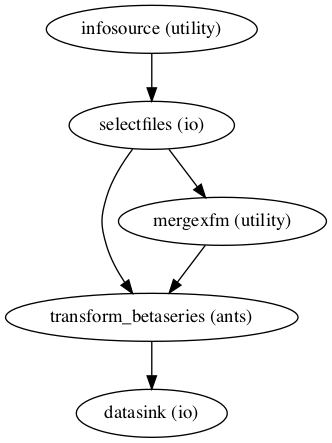

In [ ]:
from IPython.display import Image
Image(filename="/data/mvs/derivatives/derivatives/nibetaseries/nibetaseries_transform/working_dir/transform_betaseries_ANTS_flow/graph.png")

and second, the detailed one:

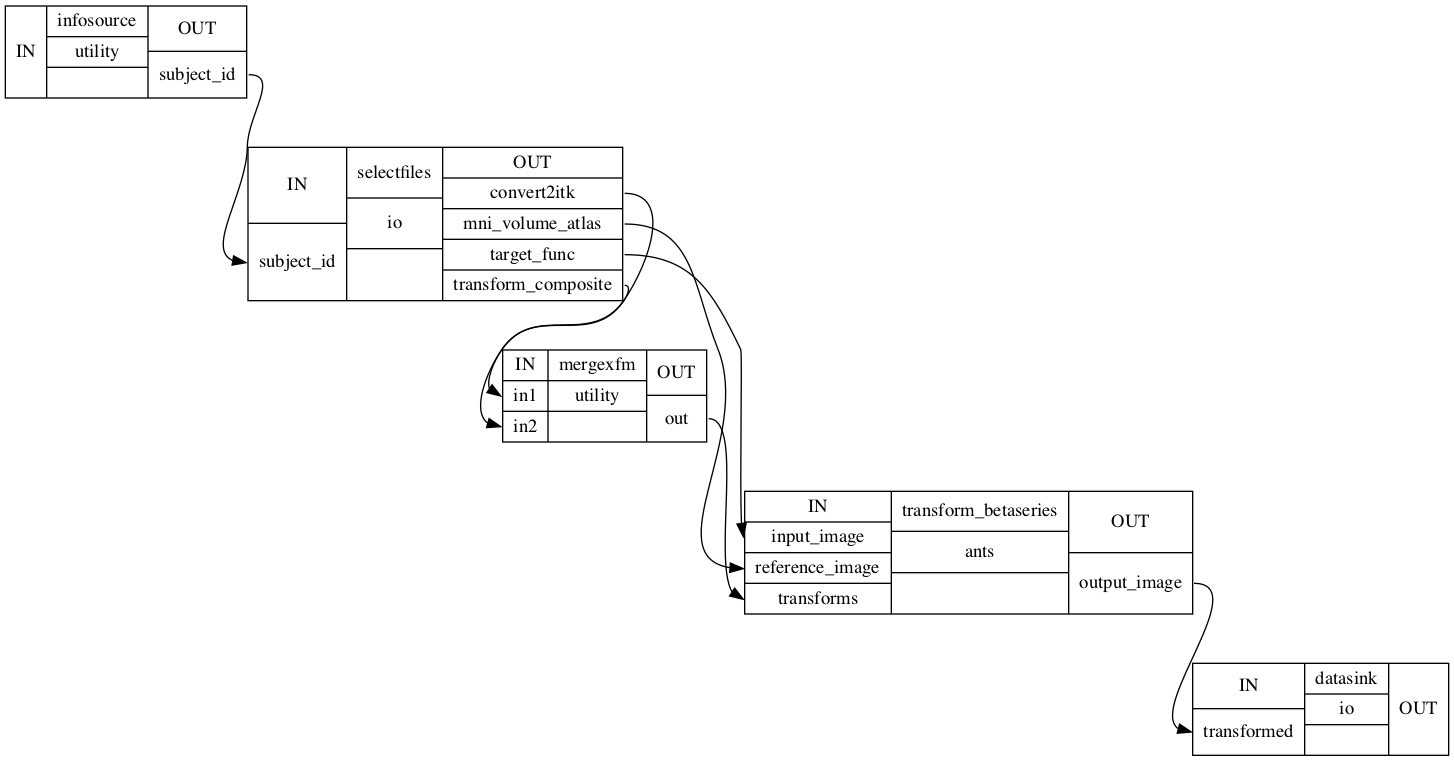

In [ ]:
Image(filename="/data/mvs/derivatives/derivatives/nibetaseries/nibetaseries_transform/working_dir/transform_betaseries_ANTS_flow/graph_detailed.png")

Again, we will not run this part here, but us precomputed outputs as shown in the next step. However, here is how this was done:

In [ ]:
transform_betaseries_ANTS_flow.run('MultiProc', plugin_args={'n_procs':4})

Speaking of which, it's finally time to download the respective files from the project's [OSF page]() via the [osf client](). The files we are going to download are the outcomes of the steps above. Please note, that they are rather large in size (`~4.5 GB`) and thus things will take a while. 

In [ ]:
osf -p <projectid> fetch remote/path.txt local/file.txt

The outputs from the this step will now be used to conduct two complementary correlation analyses: `ROI to ROI` and `voxel to voxel correlations`. Both aim to provide insights into the `condition specific information flow` within the `auditory cortex`, however at different spatial scales. 